In [17]:
import pandas as pd
import glob
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from joblib import load
import joblib

In [8]:
# Load cleaned data
files = sorted(glob.glob('../data/products_clean_part_*.parquet'))
df_clean = pd.concat([pd.read_parquet(f) for f in files], ignore_index=True)

print(f"Loaded DataFrame shape: {df_clean.shape}")

Loaded DataFrame shape: (726804, 8)


In [9]:
df_sample=df_clean.sample(100_000, random_state=42)
# Let's define the predictors from the 
X = df_sample[['title', 'description', 'feature', 'brand', 'price']]
y = df_sample['main_cat']

## Preprocessing pipeline
To classify the amazon product we will be using a Lineal SVM model that cannot work directly with text or raw data, the model needs numeric feature vectors. 

As a previous preprocessing step, we are going to use ColumnTransformer to apply:
- TF-IDF to transform text columns ('title', 'description', etc) into  numeric vectors.
- StandardScale to numerical column ('price'), in order to standarize the price columns (mean = 0, std = 1).

In [10]:
# Processign pipeline

# Preprocessing by column
preprocessor = ColumnTransformer(
    transformers=[
        ('title_tfidf', TfidfVectorizer(max_features=5000), 'title'),
        ('desc_tfidf', TfidfVectorizer(max_features=5000), 'description'),
        ('feature_tfidf', TfidfVectorizer(max_features=3000), 'feature'),
        ('brand_tfidf', TfidfVectorizer(max_features=1000), 'brand'),
        ('scaler', StandardScaler(), ['price']),
    ],
    remainder='drop'
)

Now, we need to apply transformations and train the model on the transformed data. Making sure that we handle the 'main_cat' class imbalance (with class_weight), we use CPU to train as fast as possible, and we select the proper loss function:

In [11]:
# Classifier
model = SGDClassifier(loss='log_loss', class_weight='balanced', max_iter=1000, n_jobs=-1)
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', model )
])


In [12]:
# Split into test and train sets for the model
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)

# Evaluation
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

y = df_sample['main_cat_grouped']

                           precision    recall  f1-score   support

          All Electronics       0.66      0.38      0.48      1121
           Amazon Fashion       0.93      0.98      0.96      1425
              Amazon Home       0.72      0.71      0.71      1612
    Arts, Crafts & Sewing       0.79      0.83      0.81      1436
               Automotive       0.80      0.84      0.82      1284
                    Books       0.00      0.00      0.00         2
           Camera & Photo       0.80      0.85      0.82       844
Cell Phones & Accessories       0.81      0.84      0.83      1107
                Computers       0.78      0.79      0.79      1434
                  Grocery       0.68      0.79      0.73        29
   Health & Personal Care       0.04      0.04      0.04        23
     Home Audio & Theater       0.56      0.75      0.64       750
  Industrial & Scientific       0.34      0.60      0.44       207
      Musical Instruments       0.88      0.85      0.87     

- Overall accuracy ~78%.

- More FrequentClasses like Amazon Fashion, Pet Supplies, and Video Games have very high precision and recall — the model handles these well.

- Some categories like Books and Health & Personal Care have very low precision, recall, and F1 scores (close to zero), the model hardly predicts these classes at all. Indicating performance suffers on smaller classes.

Let´s try the same model but using as target variable : 'main_cat_grouped'

In [13]:
y = df_sample['main_cat_grouped']

# Split into test and train sets for the model
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)

# Evaluation
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

                           precision    recall  f1-score   support

          All Electronics       0.66      0.38      0.48      1121
           Amazon Fashion       0.94      0.99      0.96      1425
              Amazon Home       0.72      0.72      0.72      1612
    Arts, Crafts & Sewing       0.81      0.83      0.81      1436
               Automotive       0.79      0.84      0.81      1284
           Camera & Photo       0.80      0.85      0.82       844
Cell Phones & Accessories       0.81      0.85      0.83      1107
                Computers       0.77      0.79      0.78      1434
     Home Audio & Theater       0.57      0.73      0.64       750
  Industrial & Scientific       0.44      0.67      0.53       207
      Musical Instruments       0.87      0.87      0.87       790
          Office Products       0.80      0.75      0.78      1502
                    Other       0.33      0.43      0.37        54
             Pet Supplies       0.92      0.91      0.91     

- Now, it looks like the 'Other' category is properly handled, improving stability when compared to previous evaluation.

- Scores have gone up for many categories, and look mmore stable. Additionally the average metrics (macro avg and weighted avg) improved. Which means the class imbalance has improved. 

For further model evaluation, we are going to calculate the Confusion Matrix:

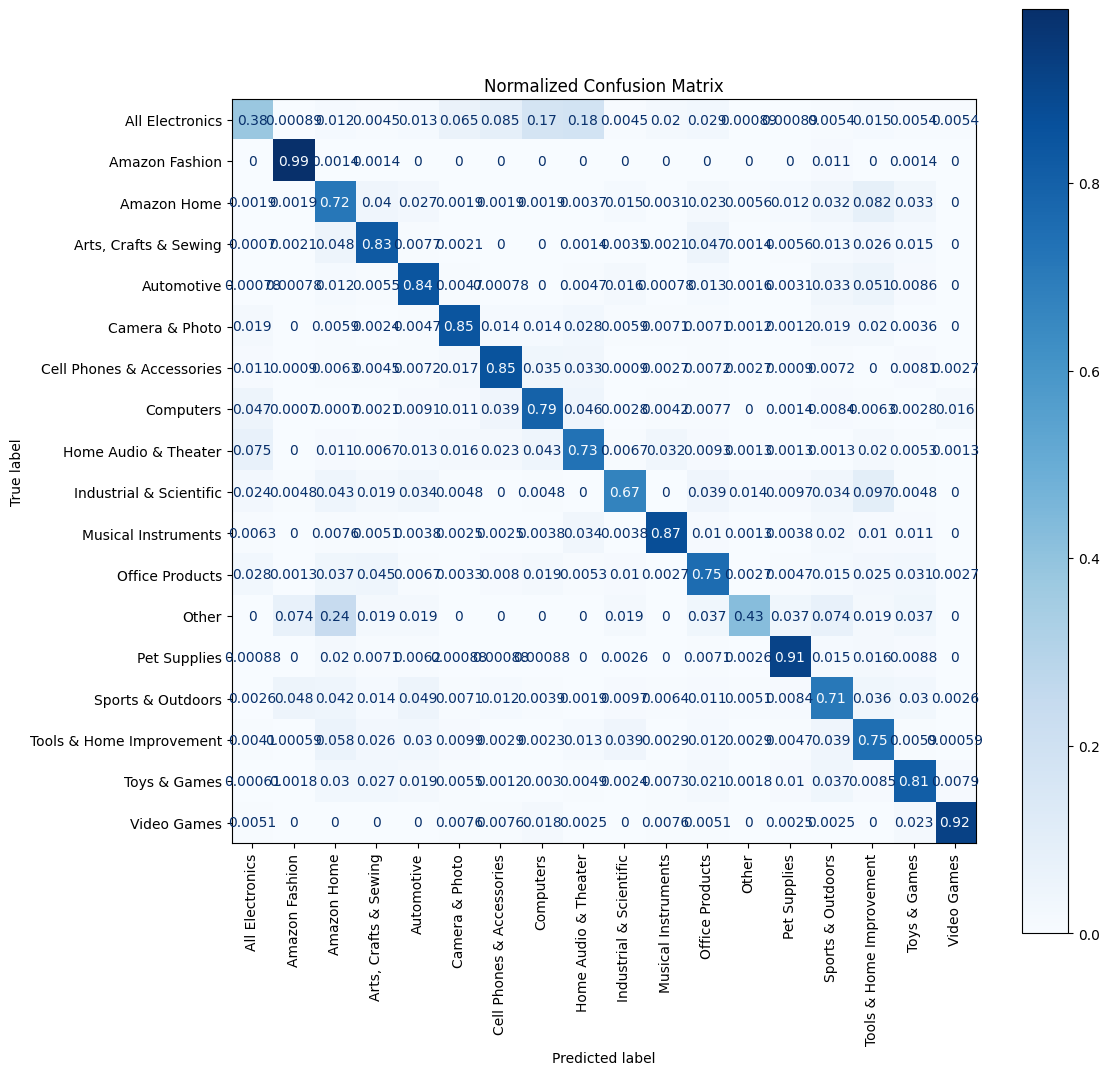

In [15]:
def plot_confusion_matrix(estimator, X_test, y_test, labels=None, normalize='true'):
    """
    Plots confusion matrix with normalization option.
    """
    y_pred = estimator.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=labels, normalize=normalize)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(12, 12))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title("Normalized Confusion Matrix")
    plt.xticks(rotation=90)
    plt.show()

labels = pipeline.classes_  
plot_confusion_matrix(pipeline, X_test, y_test, labels=labels)

From the above matrix we have learnt the following:
- In the diagonal we see the correct predictions per class are high numbers, close to 1. Except for 'All Electronics´with a 0.38 and 'Other' with a 0.43.
- There are no high values in off-diagonal cells, which means we do not have to worry about the model confusing classes with each other.

This results align with:
- The low recall for 'All Electronics' (recall = 0.38)
- The low precision value for 'Others' (precision = 0.37)

In [ ]:
## Save model1 and preprocessor1
model1 = model
#joblib.dump(model1, 'model1.joblib')
#joblib.dump(preprocessor, 'preprocessor1.joblib')
joblib.dump(pipeline, 'api/pipeline1.joblib')